<a href="https://colab.research.google.com/github/leedain0301/Data_MiniProject_02/blob/main/MiniProject_02_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 아파트 실거래가 예측


> 한국의 주거 형태는 약 50%가 아파트이고, 
> 재태크 수단으로서도 아파트 매매가에 관심도가 높습니다.
>
>아파트 실거래가 예측 데이터 분석은 중개사와 구매자를 연결하여 부동산정보 서비스 시장의 신뢰도를 높이고, 아파트 구매자들의 정보 불균형을 해결하기 위해 미래의 실 거래가 예측을 목표로 합니다.
>
> 이 데이터는 부동산 기업 앱 '직방'에서 데이터를 제공 받았고, 서울 아파트 실거래가 2008 ~ 2017년도 정보를 가지고 있습니다.





## 컬럼 설명

###   train.csv / test.csv <br>
>  : 서울 지역의 740,000여개 거래 데이터, 아파트 거래일, 지역, 전용면적, 실 거래가 등의 정보

- **features**
  *   transaction_id : 아파트 거래 유일키키
  *   apartment_id : 아파트 아이디
  *   city : 도시
  *   dong : 동
  *   jibun : 지번
  *   apt : 아파트단지 이름
  *   addr_kr : 주소
  *   exclusive_use_area : 전용면적
  *   year_of_completion : 설립일자
  *   transaction_year_month : 거래년월
  *   transaction_date : 거래날짜
  *   floor : 층
  *   transaction_real_price : 실거래가(train 만 존재)



<br>

---

<br>









In [208]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import sklearn
from sklearn.linear_model    import ElasticNet, Lasso
from sklearn.ensemble        import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge    import KernelRidge
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import RobustScaler, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics         import mean_squared_error, accuracy_score

from category_encoders       import OneHotEncoder, OrdinalEncoder

import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import sys

In [210]:
train_data = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/test.csv')
submission_data = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/submission.csv')

print('train.csv. Shape: ',train_data.shape)
print('test.csv. Shape: ', test_data.shape)

train.csv. Shape:  (1216553, 13)
test.csv. Shape:  (5463, 12)


In [211]:
# 서울/부산->부산 데이터 삭제
train_data.drop(train_data[(train_data['city'] == '부산광역시')].index, inplace=True)
test_data.drop(test_data[(test_data['city'] == '부산광역시')].index, inplace=True)

In [212]:
# train_data.head()

In [213]:
# test_data.head()

In [214]:
# train_data.info()

In [215]:
# test_data.info()

In [216]:
train_data.duplicated().sum()

0

In [217]:
test_data.duplicated().sum()

0

In [218]:
train_null = train_data.drop('transaction_real_price', axis=1).isnull().sum()/len(train_data)*100
test_null = test_data.isnull().sum()/len(test_data)*100
pd.DataFrame({'train_null_count': train_null,'test_null_count':test_null})

,train_null_count,test_null_count
transaction_id,0.0,0.0
apartment_id,0.0,0.0
city,0.0,0.0
dong,0.0,0.0
jibun,0.0,0.0
apt,0.0,0.0
addr_kr,0.0,0.0
exclusive_use_area,0.0,0.0
year_of_completion,0.0,0.0
transaction_year_month,0.0,0.0


In [219]:
train_data.nunique()

transaction_id            742285
apartment_id                8251
city                           1
dong                         330
jibun                       6119
apt                         6917
addr_kr                     8251
exclusive_use_area         12475
year_of_completion            54
transaction_year_month       119
transaction_date               6
floor                         73
transaction_real_price     12301
dtype: int64

<br>

---
<br>

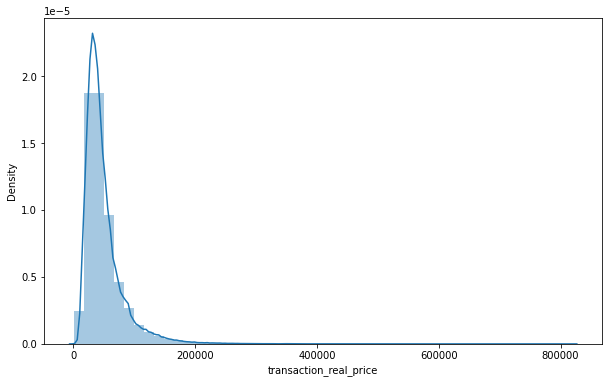

In [220]:
f,ax=plt.subplots(figsize=(10,6))
sns.distplot(train_data['transaction_real_price'])

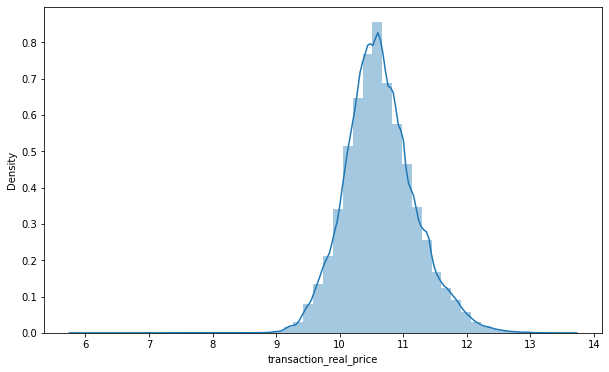

In [221]:
train_data['transaction_real_price'] = np.log1p(train_data['transaction_real_price'])
f,ax=plt.subplots(figsize=(10,6))
sns.distplot(train_data['transaction_real_price'])

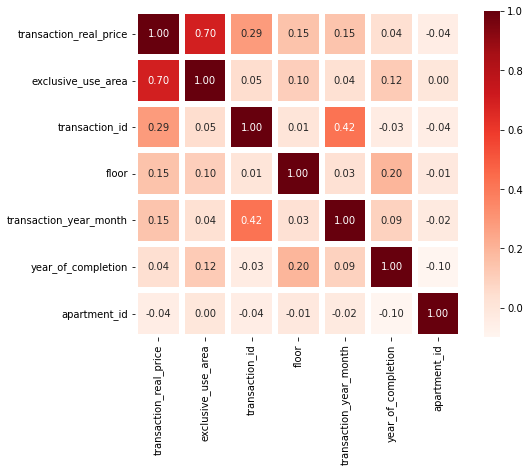

In [222]:
k = train_data.shape[1]
corrmat = train_data.corr()
cols = corrmat.nlargest(k,'transaction_real_price')['transaction_real_price'].index
cm = np.corrcoef(train_data[cols].values.T)
f,ax = plt.subplots(figsize=(8,6))
sns.heatmap(data=cm,
            annot = True,
            square=True,
            fmt='.2f',
            linewidths=5,
            cmap='Reds',
            yticklabels=cols.values,
            xticklabels=cols.values
            )

In [223]:
# 필요없는 컬럼 삭제
drop_columns=['transaction_id', 'apartment_id','city','jibun','apt','addr_kr']

train_drop = train_data[drop_columns]
test_drop = test_data[drop_columns]

train = train_data.drop(drop_columns,axis=1)
test = test_data.drop(drop_columns,axis=1)
train.head()

,dong,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,신교동,84.82,2002,200801,21~31,2,10.532123
1,필운동,99.17,1973,200801,1~10,6,9.903538
2,필운동,84.74,2007,200801,1~10,6,10.558439
3,내수동,146.39,2003,200801,11~20,15,11.678448
4,내수동,194.43,2004,200801,21~31,3,11.695255


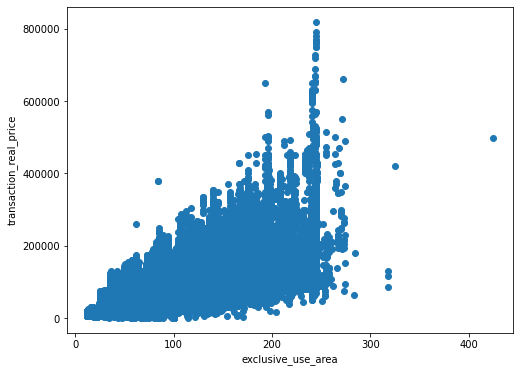

In [224]:
train['transaction_real_price'] = np.expm1(train_data['transaction_real_price'])

f,ax=plt.subplots(figsize=(8,6))
plt.scatter(train['exclusive_use_area'],train['transaction_real_price'])
plt.xlabel('exclusive_use_area')
plt.ylabel('transaction_real_price')
plt.show()

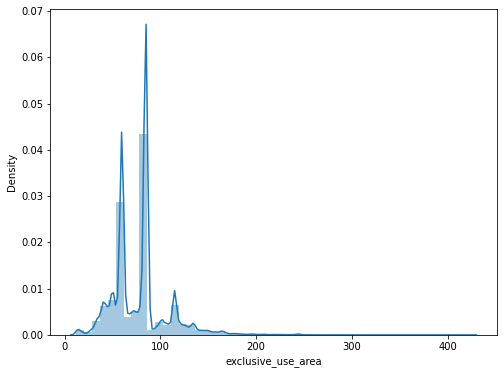

In [225]:
f,ax=plt.subplots(figsize=(8,6))
sns.distplot(train['exclusive_use_area'])

In [226]:
# train[train['floor'] < 0].head() #오마이갓...지하가 있었어...

floor->Skewness: 0.032724, Kurtosis: -0.670766


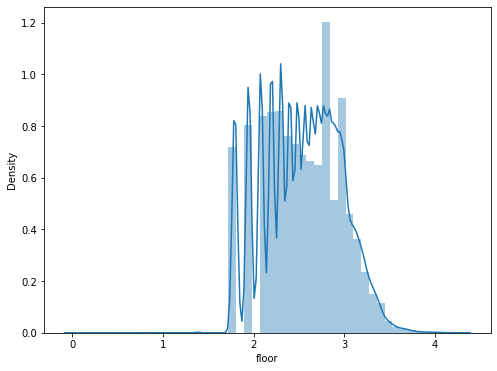

In [227]:
# floor에 -1가 있어서 log처리

train['floor']=np.log(train['floor']+5)
test['floor']=np.log(test['floor']+5)
f,ax=plt.subplots(figsize=(8,6))
sns.distplot(train['floor'])
print("%s->Skewness: %f, Kurtosis: %f"%('floor',train['floor'].skew(),train['floor'].kurt()))

In [228]:
train_test_data=[train,test]
for dataset in train_test_data:
    dataset['transaction_year_month']=dataset['transaction_year_month'].astype(str)
    dataset['year']=dataset['transaction_year_month'].str[:4].astype(int)
    dataset['month']=dataset['transaction_year_month'].str[4:6].astype(int)
    dataset['transaction_year_month']=dataset['transaction_year_month'].astype(int)

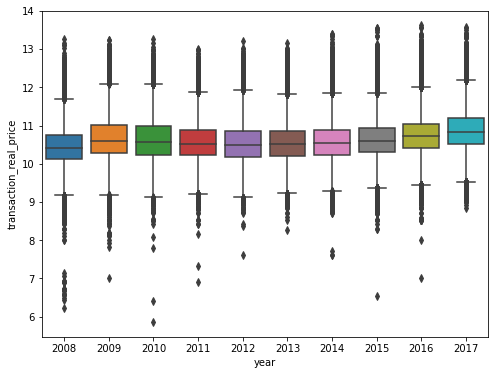

In [229]:
train['transaction_real_price'] = np.log1p(train['transaction_real_price'])
f,ax=plt.subplots(figsize=(8,6))
sns.boxplot(train['year'],train['transaction_real_price'])
plt.show()

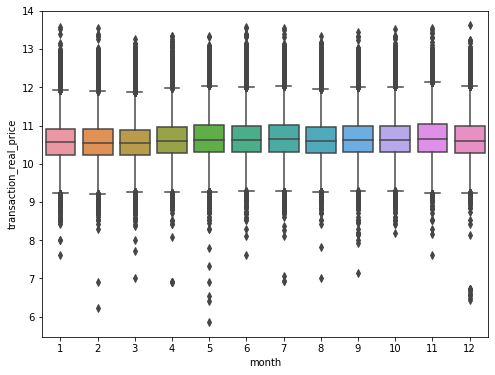

In [230]:
f,ax=plt.subplots(figsize=(8,6))
sns.boxplot(train['month'],train['transaction_real_price'])
plt.show()

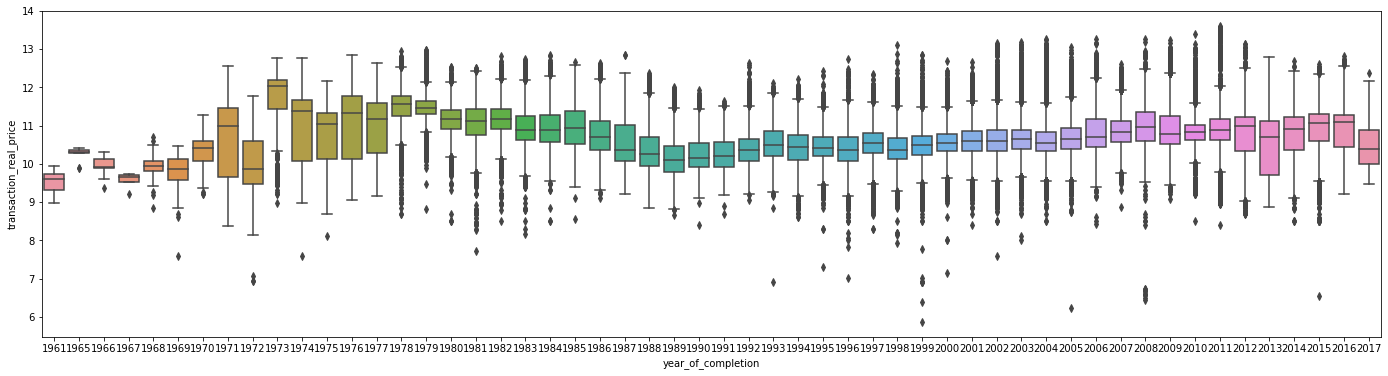

In [231]:
f,ax=plt.subplots(figsize=(24,6))
sns.boxplot(train['year_of_completion'],train['transaction_real_price'])
plt.show()

In [232]:
# 이상치 확인용용
# train[train['year_of_completion']==1999].sort_values('transaction_real_price',ascending=True)

In [233]:
# 필요없는 컬럼 삭제
drop_columns=['transaction_year_month']

train_drop2 = train['transaction_year_month']
test_drop2 = test['transaction_year_month']

train = train.drop(drop_columns,axis=1)
test = test.drop(drop_columns,axis=1)
train.head()

,dong,exclusive_use_area,year_of_completion,transaction_date,floor,transaction_real_price,year,month
0,신교동,84.82,2002,21~31,1.945910,10.532123,2008,1
1,필운동,99.17,1973,1~10,2.397895,9.903538,2008,1
2,필운동,84.74,2007,1~10,2.397895,10.558439,2008,1
3,내수동,146.39,2003,11~20,2.995732,11.678448,2008,1
4,내수동,194.43,2004,21~31,2.079442,11.695255,2008,1


In [234]:
# 인코딩딩
encoder = OrdinalEncoder()
train_encoded = encoder.fit_transform(train) 
test_encoded = encoder.fit_transform(test) 
train_encoded.head()

,dong,exclusive_use_area,year_of_completion,transaction_date,floor,transaction_real_price,year,month
0,1,84.82,2002,1,1.945910,10.532123,2008,1
1,2,99.17,1973,2,2.397895,9.903538,2008,1
2,2,84.74,2007,2,2.397895,10.558439,2008,1
3,3,146.39,2003,3,2.995732,11.678448,2008,1
4,3,194.43,2004,1,2.079442,11.695255,2008,1


In [235]:
# 필요없는 컬럼 삭제2
encoded_columns=['exclusive_use_area','floor','transaction_real_price']

train_encoded = train_encoded.astype({'exclusive_use_area':'int64', 'floor':'int64', 'transaction_real_price':'int64'})
test_encoded = test_encoded.astype({'exclusive_use_area':'int64', 'floor':'int64'})

train = train_encoded
test = test_encoded

train.head()

,dong,exclusive_use_area,year_of_completion,transaction_date,floor,transaction_real_price,year,month
0,1,84,2002,1,1,10,2008,1
1,2,99,1973,2,2,9,2008,1
2,2,84,2007,2,2,10,2008,1
3,3,146,2003,3,2,11,2008,1
4,3,194,2004,1,2,11,2008,1


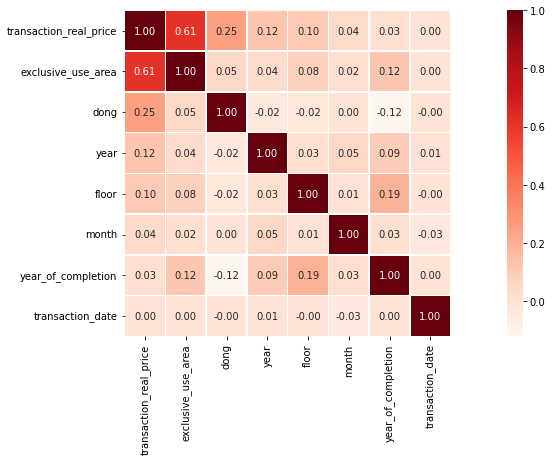

In [236]:
#상관관계 확인2
k=train.shape[1]
corrmat = train.corr() 
cols = corrmat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index 
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

In [238]:
train.to_csv('train_clean2.csv', index=False, header=False)
test.to_csv('test_clean2.csv', index=False, header=False)